9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step - accuracy: 0.0408 - loss: 0.0131 - val_accuracy: 0.3731 - val_loss: -2.3701
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.2963 - loss: -1.9477 - val_accuracy: 0.5075 - val_loss: -6.5913
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.1061 - loss: -4.2100 - val_accuracy: 0.4478 - val_loss: -7.6992
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.2396 - loss: -6.2438 - val_accuracy: 0.4627 - val_loss: -11.7307
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.2311 - loss: -9.4270 - val_accuracy: 0.4627 - val_loss: -15.1094
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.2406 - loss: -12.8186 - val_accuracy: 0.4627 - val_loss: -20.2461
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.2537 - loss: -13.5406 - val_accuracy: 0.4776 - val_loss: -25.2644
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accur

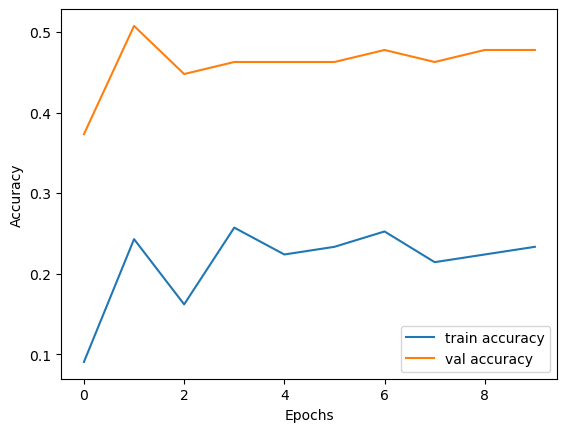

In [15]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Parameters
n_mfcc = 40
max_len = 128  # Number of time frames for MFCCs
img_size = (128, 128)  # MobileNetV2 expects at least 96x96, commonly 128x128

def extract_mfcc_image(file_path, n_mfcc=n_mfcc, max_len=max_len, img_size=img_size):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # Pad or truncate time axis
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    # Resize to img_size (e.g., 128x128) for MobileNetV2
    mfcc_img = tf.image.resize(mfcc[np.newaxis, ..., np.newaxis], img_size).numpy()[0, ..., 0]
    # Stack to 3 channels
    mfcc_img = np.stack([mfcc_img]*3, axis=-1)
    return mfcc_img

def prepare_dataset(audio_dir):
    features = []
    labels = []
    for label in os.listdir(audio_dir):
        class_dir = os.path.join(audio_dir, label)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_dir, file_name)
                    mfcc_img = extract_mfcc_image(file_path)
                    features.append(mfcc_img)
                    labels.append(label)
    features = np.array(features, dtype=np.float32)
    labels = np.array(labels)
    return features, labels

# Directories
train_directory = 'cats_dogs/train'  # Should contain 'dog' and 'cat' folders
test_directory = 'cats_dogs/test'

# Prepare data
X_train, y_train = prepare_dataset(train_directory)
X_test, y_test = prepare_dataset(test_directory)

# Normalize images to [0, 1]
X_train /= 255.0
X_test /= 255.0

# Encode labels: 'dog' = 1, 'cat' = 0
label_encoder = LabelEncoder()
all_labels = np.concatenate((y_train, y_test))
label_encoder.fit(all_labels)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

# Build MobileNetV2-based model
base_model = MobileNetV2(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze for transfer learning

inputs = Input(shape=img_size + (3,))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save model
model.save('dog_bark_mobilenetv2_classifier.h5')


In [16]:
import numpy as np
import librosa
import tensorflow as tf

# Parameters (must match training)
n_mfcc = 40
max_len = 128
img_size = (128, 128)

def extract_mfcc_image(file_path, n_mfcc=n_mfcc, max_len=max_len, img_size=img_size):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # Pad or truncate time axis
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    # Resize to img_size
    mfcc_img = tf.image.resize(mfcc[np.newaxis, ..., np.newaxis], img_size).numpy()[0, ..., 0]
    # Stack to 3 channels
    mfcc_img = np.stack([mfcc_img]*3, axis=-1)
    return mfcc_img

def predict_audio(model, file_path, threshold=0.5):
    mfcc_img = extract_mfcc_image(file_path)
    mfcc_img = mfcc_img.astype(np.float32) / 255.0  # normalize as during training
    mfcc_img = np.expand_dims(mfcc_img, axis=0)     # add batch dimension
    pred = model.predict(mfcc_img)[0][0]
    if pred >= threshold:
        return f"Dog ({pred:.2f})"
    else:
        return f"Not Dog ({pred:.2f})"


In [18]:
'''from tensorflow.keras.models import load_model
model = load_model('dog_bark_mobilenetv2_classifier.h5')
user_audio_path = 'videoplayback.m4a'
result = predict_audio(model, user_audio_path)
print(f"Prediction: {result}")'''


'from tensorflow.keras.models import load_model\nmodel = load_model(\'dog_bark_mobilenetv2_classifier.h5\')\nuser_audio_path = \'videoplayback.m4a\'\nresult = predict_audio(model, user_audio_path)\nprint(f"Prediction: {result}")'

In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("octopusteam/full-imdb-dataset")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 25.4M/25.4M [00:03<00:00, 7.84MB/s]

Extracting files...


Path to dataset files: C:\Users\student\.cache\kagglehub\datasets\octopusteam\full-imdb-dataset\versions\204
